In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# Any results you write to the current directory are saved as output.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# Imports

import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [4]:
# Input loading

# labels = ['PNEUMONIA', 'NORMAL']
# img_size = 150
# def get_training_data(data_dir):
#    data = [] 
#    for label in labels: 
#        path = os.path.join(data_dir, label)
#        class_num = labels.index(label)
#        for img in os.listdir(path):
#            try:
#                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
#                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
#                data.append([resized_arr, class_num])
#            except Exception as e:
#                print(e)
#    return np.array(data, dtype=object)

#train = get_training_data('../chest_xray/train')
#test = get_training_data('../chest_xray/test')
#val = get_training_data('../chest_xray/val')

# 2. Load the data

The Chest X-ray data we are using divides the data into train, val, and test files with very few files in the validation folder. We will append the validation files and create a new split that resembes the standard 80:20 division.

In [5]:
filenames = tf.io.gfile.glob(str('../chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str('../chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Non neumonia images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Non neumonia images count in training set: 1071
Pneumonia images count in training set: 3114


There are more images that are classified as pneumonia than normal. We have an imbalance dataset.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(3):
    print(f.numpy())

b'../chest_xray/train/NORMAL/NORMAL2-IM-1236-0001.jpeg'
b'../chest_xray/train/PNEUMONIA/person33_bacteria_173.jpeg'
b'../chest_xray/train/NORMAL/NORMAL2-IM-0535-0001-0002.jpeg'


2022-11-24 08:40:04.617480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
TRAIN_IMAGE_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMAGE_COUNT))

VAL_IMAGE_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMAGE_COUNT))

Training images count: 4185
Validating images count: 1047


In [9]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str("../chest_xray/train/*"))])
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

We want to map each filename to the corresponding (image, label) pair.

In [10]:
def get_label(file_path):
    # Turn the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [12]:
def process_path(file_path):
    label = get_label(file_path)
    # load raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


Loading and formatting the test data too.

In [16]:
test_list_ds = tf.data.Dataset.list_files(str('../chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

# 3. Visualize the dataset

We will use buffered prefetching

In [17]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [18]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

2022-11-24 08:40:30.946317: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [19]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(12):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

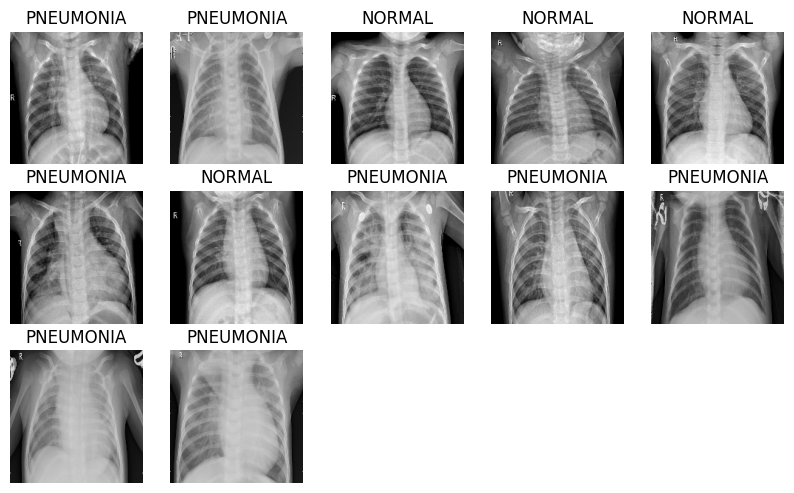

In [20]:
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. Correct for data imbalance

In [21]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.06731528])

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMAGE_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMAGE_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


# 5. Build the CNN

In [23]:
# Training the Model

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 64)       2

# 7. Finetune the model

We use Keras callbacks to finetune our model. The checkpoint callback saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it. The early stopping callback stops the training process when the model starts becoming stagnant, or when the model starts overfitting. Since we set `restore_best_weights` to `True`, the returned model at the end of the training process will be the model with the best weights (i.e. low loss and high accuracy).

In [24]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("pneumonia_model.h5",
                                                    save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [25]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TEST_IMAGE_COUNT // BATCH_SIZE,
    epochs=50,
    validation_data=val_ds,
    validation_steps=VAL_IMAGE_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks = [checkpoint_callback, early_stopping_callback,learning_rate_reduction]
)

Epoch 1/50


# 8. Visualizing model performance


In [75]:
loss, accuracy = model.evaluate(test_ds)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , accuracy*100 , "%")

20/20 [==============================] - 12s 554ms/step - loss: 4.4442 - accuracy: 0.7532
Loss of the model is -  4.444211483001709
Accuracy of the model is -  75.32051205635071 %


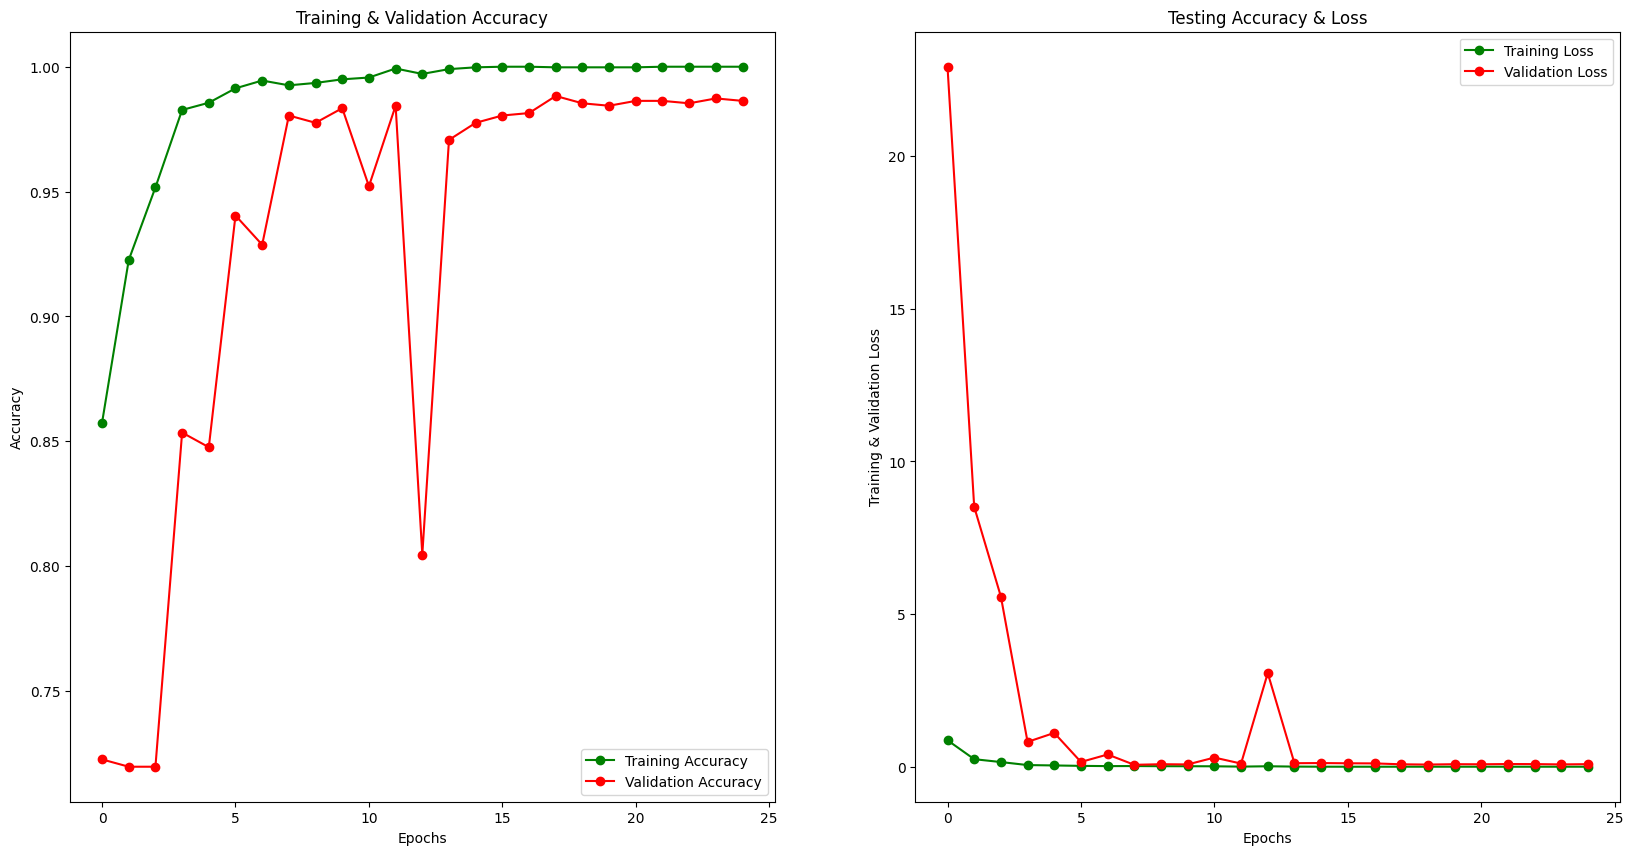

In [76]:
# Analysis after Model Training

epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

KeyError: 'precision'

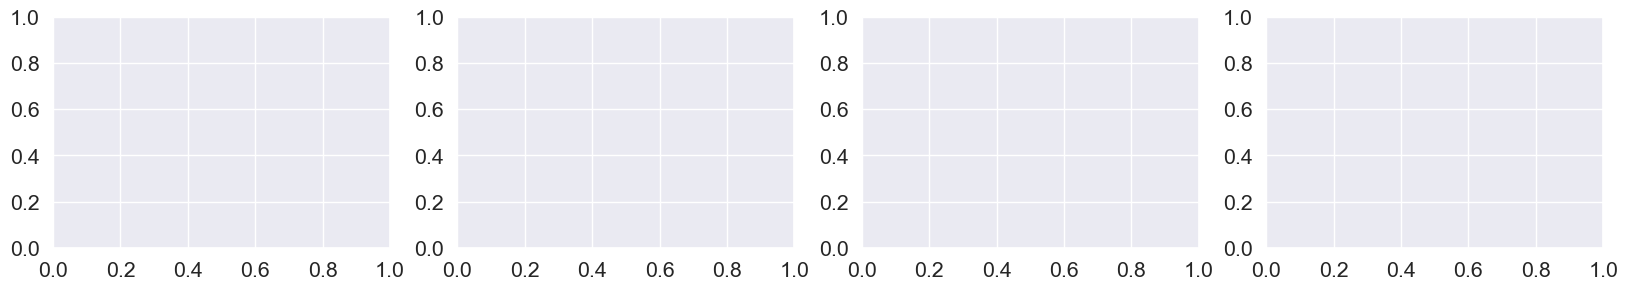

In [83]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 9. Predict and evaluate results

In [78]:
# Predictions

predictions = (model.predict(test_ds) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 12s 570ms/step


array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

Hasta acá llegué por ahora

In [79]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

ValueError: Found input variables with inconsistent numbers of samples: [20, 624]

In [80]:
cm = confusion_matrix(y_test,predictions)
cm

ValueError: Found input variables with inconsistent numbers of samples: [20, 624]

In [81]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

NameError: name 'cm' is not defined

In [82]:
plt.figure(figsize = (7,7))
sns.set(font_scale=1.4)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labels, yticklabels = labels)

NameError: name 'cm' is not defined

<Figure size 700x700 with 0 Axes>

In [26]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

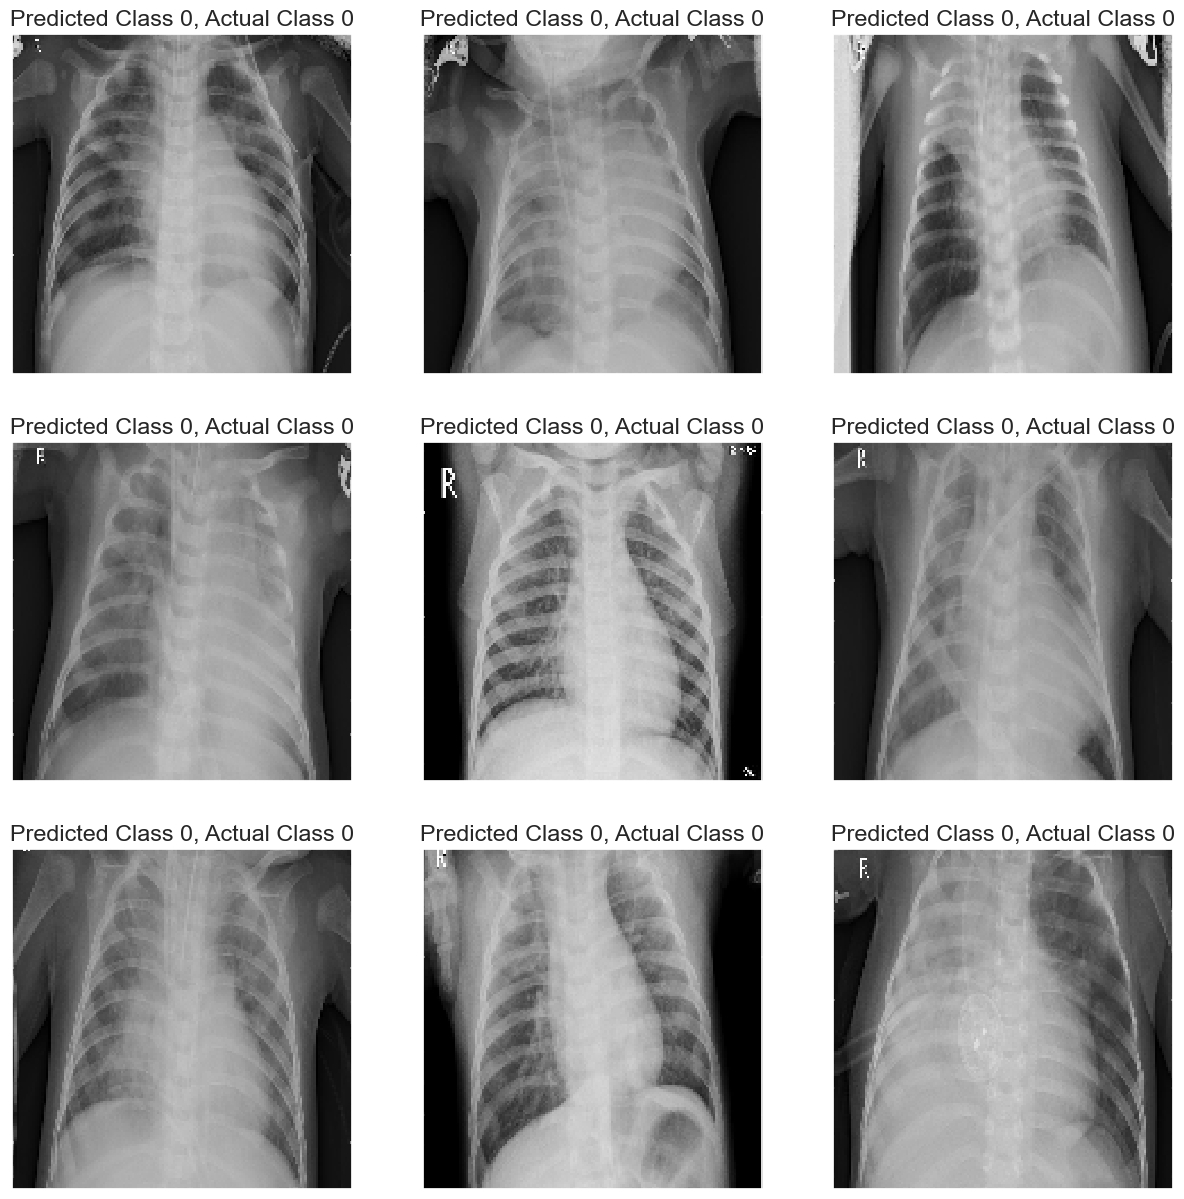

In [27]:
# Some of the Correctly Predicted Classes

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(2):
    for j in range(3):
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        axs[i, j].imshow(x_test[correct[3*i+j]].reshape(180,180), cmap="gray", interpolation='none')
        axs[i, j].set_title("Predicted Class {}, Actual Class {}".format(predictions[correct[3*i+j]], y_test[correct[3*i+j]]))

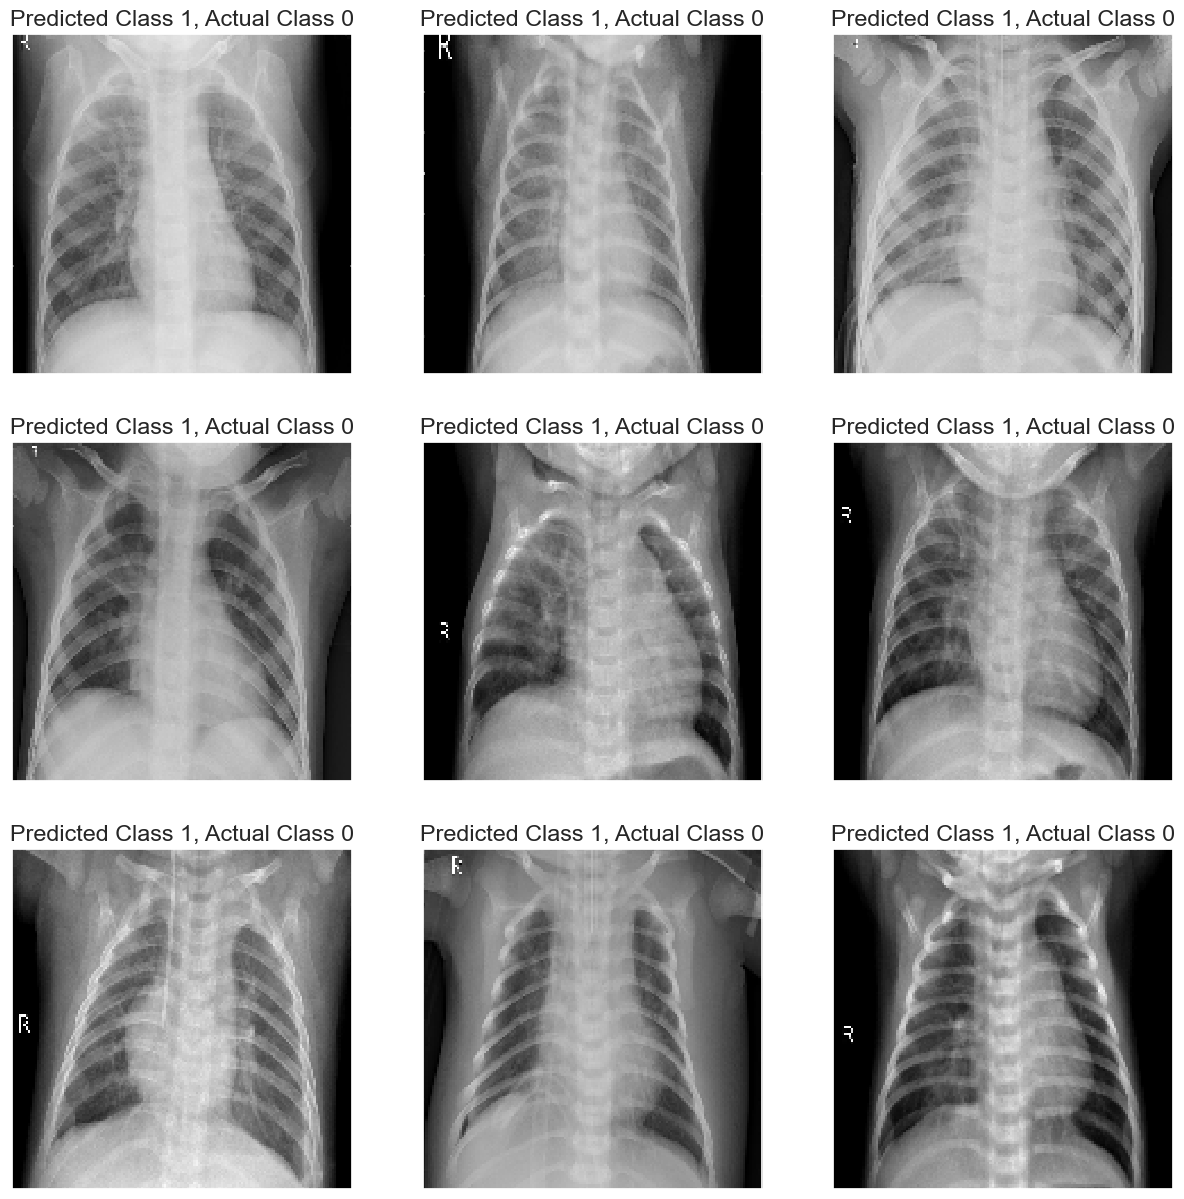

In [28]:
# Some of the Incorrectly Predicted Classes

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(2):
    for j in range(3):
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        axs[i, j].imshow(x_test[incorrect[3*i+j]].reshape(180,180), cmap="gray", interpolation='none')
        axs[i, j].set_title("Predicted Class {}, Actual Class {}".format(predictions[incorrect[3*i+j]], y_test[incorrect[3*i+j]]))